In [70]:
import pandas as pd
import numpy as np
import os
import random
import pathlib
import joblib
import glob
import random
from imutils import rotate as rotate
from itertools import product
import PIL
from PIL import Image
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches
from matplotlib.patches import Polygon


from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import cv2 as cv
import skimage.io as skio

# Required to read the data from Kaggle
from google.colab import drive
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!kaggle datasets download -d andrewmvd/isic-2019 --force

100% 9.09G/9.10G [06:18<00:00, 28.5MB/s]
100% 9.10G/9.10G [06:19<00:00, 25.8MB/s]


In [3]:

!unzip \*.zip  && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065358.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065359.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065360.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065361.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065362.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065366.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065367.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065368.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065370.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065371.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0065372.jpg  
  inflating: ISIC_2019_Training_Input/ISIC_2019

In [4]:
!wc -l ISIC_2019_Training_GroundTruth.csv
!rm -rf /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/MEL
!rm -rf /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/NV
!rm -rf /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/BCC
!rm -rf /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/UNK
!rm -rf /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/AK
!rm -rf /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/BKL
!rm -rf /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/DF
!rm -rf /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/VASC
!rm -rf /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/SCC

25332 ISIC_2019_Training_GroundTruth.csv


In [8]:
orig_label_file = 'ISIC_2019_Training_GroundTruth.csv'
orig_label = pd.read_csv(orig_label_file)
print("Number of rows ", len(orig_label.index))
orig_label = shuffle(orig_label)
print("Number of rows ", len(orig_label.index))

split = (0.8, 0.1, 0.1)
split_indices = np.multiply(len(orig_label), split).astype(int)
for idx, val in enumerate(split_indices):
    print(idx, val)
    if idx > 0:
        split_indices[idx] = sum(split_indices[idx - 1 : idx]) + split_indices[idx]
print("Split indecs : ", split_indices)


train_label = orig_label[: split_indices[0]]
test_label = orig_label[split_indices[0] : split_indices[1]]
val_test = orig_label[split_indices[1]:]

print("Train Label Size: ",train_label.size)

Number of rows  25331
Number of rows  25331
0 20264
1 2533
2 2533
Split indecs :  [20264 22797 25330]
Train Label Size:  202640


In [11]:
val_test

image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
15478  ISIC_0057600  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
17503  ISIC_0060809  0.0  0.0  0.0  0.0  0.0  1.0   0.0  0.0  0.0
3821   ISIC_0025224  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
17745  ISIC_0061195  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3306   ISIC_0024709  0.0  0.0  0.0  0.0  1.0  0.0   0.0  0.0  0.0
...             ...  ...  ...  ...  ...  ...  ...   ...  ...  ...
18159  ISIC_0061868  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
15570  ISIC_0057760  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
10667  ISIC_0032070  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3551   ISIC_0024954  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
6299   ISIC_0027702  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0

[2534 rows x 10 columns]

In [12]:
!ls /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/MEL

ls: cannot access '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/MEL': No such file or directory


In [13]:
import shutil
var_list =['MEL', 'NV','BCC','AK','BKL','DF','VASC','SCC','UNK']
labels = train_label.melt(id_vars =['image'], value_vars =['MEL', 'NV','BCC','AK','BKL','DF','VASC','SCC','UNK'])
labels = labels.loc[labels['value'] == 1.0]
labels= labels.drop(labels.columns[2],axis=1)

base_path = '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/'
train_base_path = '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/'
isExist = os.path.exists(train_base_path)
if not isExist:
  os.mkdir(train_base_path)  

for value in var_list:
  path = train_base_path+value
  isExist = os.path.exists(path)
  if not isExist:
    os.mkdir(path)
    print("The new directory is created!")

labels
for index, row in labels.iterrows():
  source = base_path+row['image']+'.jpg';
  dest = train_base_path+row['variable']+'/'+row['image']+'.jpg'
  im = Image.open(source)
  width, height = im.size
  newsize = (96, 96)
  im1 = im.resize(newsize)
  im1.save(source)
  shutil.move(source,dest)
  print(source,dest)
    

   


Streaming output truncated to the last 5000 lines.
/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0059180.jpg /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/BCC/ISIC_0059180.jpg
/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0056374.jpg /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/BCC/ISIC_0056374.jpg
/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0055209.jpg /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/BCC/ISIC_0055209.jpg
/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0028871.jpg /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/BCC/ISIC_0028871.jpg
/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0056661.jpg /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/BCC/ISIC_0056661.jpg
/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/ISIC_0070197.jpg /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Trai

Moving test images to Test directory

In [14]:
!ls /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/MEL

ISIC_0000002.jpg	      ISIC_0033616.jpg	ISIC_0062359.jpg
ISIC_0000004.jpg	      ISIC_0033619.jpg	ISIC_0062364.jpg
ISIC_0000013.jpg	      ISIC_0033624.jpg	ISIC_0062389.jpg
ISIC_0000022_downsampled.jpg  ISIC_0033630.jpg	ISIC_0062407.jpg
ISIC_0000026_downsampled.jpg  ISIC_0033636.jpg	ISIC_0062420.jpg
ISIC_0000029_downsampled.jpg  ISIC_0033638.jpg	ISIC_0062423.jpg
ISIC_0000031_downsampled.jpg  ISIC_0033651.jpg	ISIC_0062425.jpg
ISIC_0000035_downsampled.jpg  ISIC_0033655.jpg	ISIC_0062442.jpg
ISIC_0000043_downsampled.jpg  ISIC_0033663.jpg	ISIC_0062443.jpg
ISIC_0000046_downsampled.jpg  ISIC_0033668.jpg	ISIC_0062447.jpg
ISIC_0000049_downsampled.jpg  ISIC_0033670.jpg	ISIC_0062454.jpg
ISIC_0000054_downsampled.jpg  ISIC_0033679.jpg	ISIC_0062458.jpg
ISIC_0000056_downsampled.jpg  ISIC_0033687.jpg	ISIC_0062463.jpg
ISIC_0000074.jpg	      ISIC_0033704.jpg	ISIC_0062468.jpg
ISIC_0000078_downsampled.jpg  ISIC_0033708.jpg	ISIC_0062471.jpg
ISIC_0000139_downsampled.jpg  ISIC_0033710.jpg	ISIC_0062474.jpg
ISIC

In [15]:
var_list =['MEL', 'NV','BCC','AK','BKL','DF','VASC','SCC','UNK']
test_labels = test_label.melt(id_vars =['image'], value_vars =['MEL', 'NV','BCC','AK','BKL','DF','VASC','SCC','UNK'])
test_labels = test_labels.loc[test_labels['value'] == 1.0]
test_labels= test_labels.drop(test_labels.columns[2],axis=1)
#test_label
test_base_path = '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/'
isExist = os.path.exists(test_base_path+'Test/')
if not isExist:
    os.mkdir(test_base_path+'Test/')
    print("The new directory is created!")

test_ext_path = '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Test/'

mode = 0o777
for value in var_list:
  test_path = test_ext_path+value
  print(test_path)
  isExist = os.path.exists(test_path)
  if not isExist:
    os.mkdir(test_path)
    print("The new directory is created!")



for index, row in test_labels.iterrows():
  source = test_base_path+row['image']+'.jpg'
  dest = test_ext_path+row['variable']+'/'+row['image']+'.jpg'
  im = Image.open(source)
  width, height = im.size
  newsize = (96, 96)
  im1 = im.resize(newsize)
  im1.save(source)
  shutil.move(source,dest)

The new directory is created!
/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Test/MEL
The new directory is created!
/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Test/NV
The new directory is created!
/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Test/BCC
The new directory is created!
/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Test/AK
The new directory is created!
/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Test/BKL
The new directory is created!
/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Test/DF
The new directory is created!
/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Test/VASC
The new directory is created!
/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Test/SCC
The new directory is created!
/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Test/UNK
The new directory is created!


In [16]:
! ls -ltr /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Test/MEL/

total 1952
-rw-r--r-- 1 root root 1698 Nov 25 16:33 ISIC_0025748.jpg
-rw-r--r-- 1 root root 1848 Nov 25 16:33 ISIC_0029163.jpg
-rw-r--r-- 1 root root 2118 Nov 25 16:33 ISIC_0032733.jpg
-rw-r--r-- 1 root root 1918 Nov 25 16:33 ISIC_0071950.jpg
-rw-r--r-- 1 root root 2883 Nov 25 16:33 ISIC_0055327.jpg
-rw-r--r-- 1 root root 1863 Nov 25 16:33 ISIC_0067756.jpg
-rw-r--r-- 1 root root 1882 Nov 25 16:33 ISIC_0028291.jpg
-rw-r--r-- 1 root root 1601 Nov 25 16:33 ISIC_0059148.jpg
-rw-r--r-- 1 root root 2012 Nov 25 16:33 ISIC_0059569.jpg
-rw-r--r-- 1 root root 1714 Nov 25 16:33 ISIC_0025603.jpg
-rw-r--r-- 1 root root 1690 Nov 25 16:33 ISIC_0065195.jpg
-rw-r--r-- 1 root root 1835 Nov 25 16:33 ISIC_0028215.jpg
-rw-r--r-- 1 root root 1955 Nov 25 16:33 ISIC_0060700.jpg
-rw-r--r-- 1 root root 1881 Nov 25 16:33 ISIC_0012137_downsampled.jpg
-rw-r--r-- 1 root root 1962 Nov 25 16:33 ISIC_0033178.jpg
-rw-r--r-- 1 root root 1847 Nov 25 16:33 ISIC_0024805.jpg
-rw-r--r-- 1 root root 1777 Nov 25 16:33 ISIC_002

In [63]:
data_dir_train = pathlib.Path("/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/")
data_dir_test = pathlib.Path("/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Test/")


In [18]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

20264


Found 20264 files belonging to 9 classes.


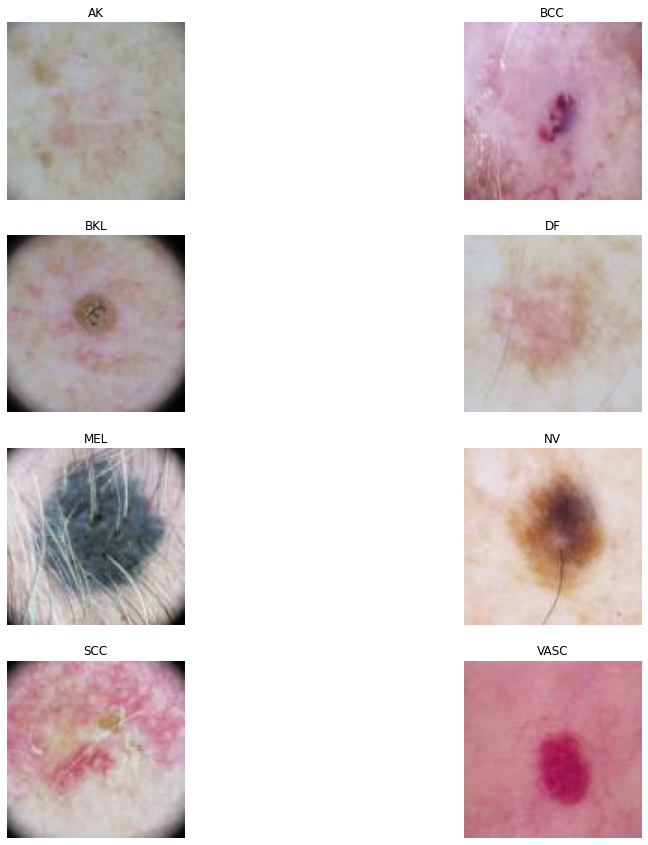

In [19]:
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(96,96),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    #print(c)
    
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    if (c!='UNK' and c!='Test'):
      path_list = files_path_dict[c][:1]
      index += 1
      #print(path_list)
      plt.subplot(4,2,index)
      plt.imshow(load_img(path_list[0],target_size=(96,96)))
      plt.title(c)
      plt.axis("off")

In [20]:
def class_distribution_count(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

Class  No. of Image
0    DF           194
1   SCC           494
2   UNK             0
3   MEL          3575
4  VASC           206
5   BKL          2100
6    NV         10309
7   BCC          2669
8    AK           717

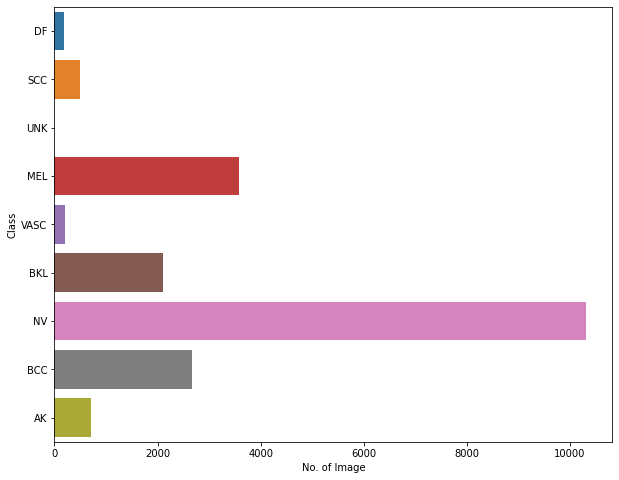

In [21]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

In [22]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
path_to_training_dataset="/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/"
import Augmentor
for i in class_names:
    if (i!='UNK'):
      p = Augmentor.Pipeline(path_to_training_dataset + i)
      p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
      p.sample(300)  #Adding 300 samples per class to make sure that none of the classes are sparse

Initialised with 717 image(s) found.
Output directory set to /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/AK/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96 at 0x7F83B068CD10>: 100%|██████████| 300/300 [00:02<00:00, 113.65 Samples/s]


Initialised with 2669 image(s) found.
Output directory set to /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/BCC/output.

Processing <PIL.Image.Image image mode=RGB size=96x96 at 0x7F83AECCED50>: 100%|██████████| 300/300 [00:02<00:00, 118.32 Samples/s]


Initialised with 2100 image(s) found.
Output directory set to /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/BKL/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96 at 0x7F83AAD67D90>: 100%|██████████| 300/300 [00:02<00:00, 104.75 Samples/s]


Initialised with 194 image(s) found.
Output directory set to /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/DF/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96 at 0x7F83AFD28150>: 100%|██████████| 300/300 [00:02<00:00, 123.38 Samples/s]


Initialised with 3575 image(s) found.
Output directory set to /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/MEL/output.

Processing <PIL.Image.Image image mode=RGB size=96x96 at 0x7F83AADA8C10>: 100%|██████████| 300/300 [00:02<00:00, 135.97 Samples/s]


Initialised with 10309 image(s) found.
Output directory set to /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/NV/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96 at 0x7F83B0689E90>: 100%|██████████| 300/300 [00:02<00:00, 148.39 Samples/s]


Initialised with 494 image(s) found.
Output directory set to /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/SCC/output.

Processing <PIL.Image.Image image mode=RGB size=96x96 at 0x7F83AADB8E90>: 100%|██████████| 300/300 [00:02<00:00, 119.78 Samples/s]


Initialised with 206 image(s) found.
Output directory set to /content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/VASC/output.

Processing <PIL.Image.Image image mode=RGB size=96x96 at 0x7F83AAD57E50>: 100%|██████████| 300/300 [00:02<00:00, 115.57 Samples/s]


In [24]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

2400


In [25]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(96,96), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 22664 files belonging to 9 classes.
Using 18132 files for training.


In [26]:
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(96,96), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 22664 files belonging to 9 classes.
Using 4532 files for validation.


In [27]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [28]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer  
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(96,96,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 96, 96, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       7

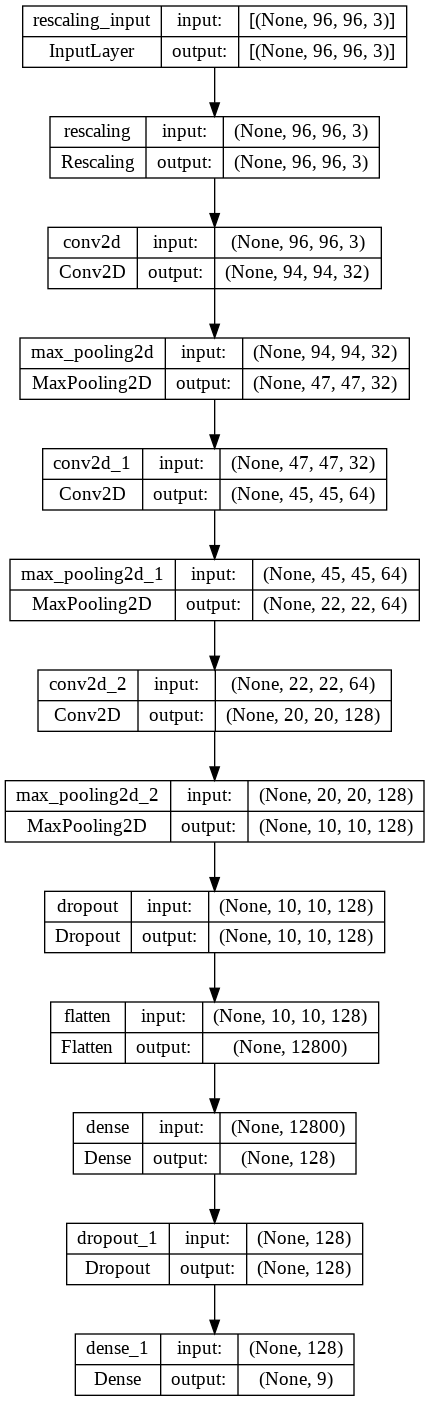

In [29]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [30]:
#Compile the Model

#Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)

In [33]:
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])

Epoch 1/20
 24/567 [>.............................] - ETA: 4:53 - loss: 1.5431 - accuracy: 0.4883

KeyboardInterrupt: ignored

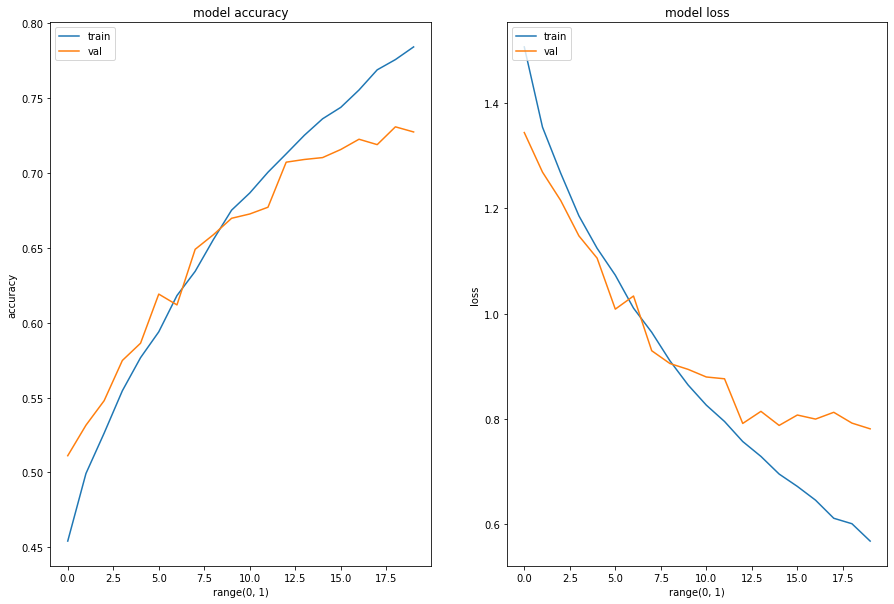

In [ ]:
epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
test_labels = test_labels.loc[test_labels['image'] == 'ISIC_0033761']
test_labels

image variable
12151  ISIC_0033761      BKL

/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Test/VASC/ISIC_0032545.jpg
1/1 [==============================] - 0s 87ms/step
Actual Class VASC
Predictive Class VASC


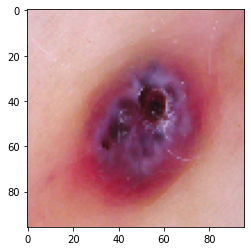

In [ ]:
from glob import glob
Test_image_path = os.path.join(test_ext_path,class_names[-1], '*')
Test_image = glob(Test_image_path)
print(Test_image[0])
Test_image = load_img(Test_image[0],target_size=(96,96,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[-1] +'\n'+ "Predictive Class "+pred_class )

**Checking the prediction for a single class VASC**

In [35]:
tf.random.set_seed(1234)
np.random.seed(1234)
from glob import glob
for c in class_names:
  if (c=='VASC'):
    Test_image_path = os.path.join(test_ext_path,c, '*')
    Test_image = glob(Test_image_path)
    total_count = 0
    match_count = 0
    for tim in Test_image:
      t_image = load_img(tim,target_size=(96,96,3))
      img = np.expand_dims(t_image,axis=0)
      pred = model.predict(img)
      pred = np.argmax(pred)
      pred_class = class_names[pred]
      total_count=total_count+1
      if c==pred_class:
        match_count=match_count+1
print(" Total test count :",total_count)
print("Correct match_count:",match_count)




1/1 [==============================] - 0s 37ms/step
 Total test count : 25
Correct match_count: 0


In [ ]:
data_dir_train

PosixPath('/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train')

In [ ]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

**VGG16 Model**

In [36]:
#CNN VGG16 Model 

#Sequential allows you to create models layer-by-layer  
model_vgg16 = Sequential()

model_vgg16.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(96,96,3)))   #Rescaling Layer

#First Convulation layer
model_vgg16.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model_vgg16.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model_vgg16.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model_vgg16.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model_vgg16.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model_vgg16.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model_vgg16.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model_vgg16.add(layers.Flatten())

#Dense Layer
model_vgg16.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model_vgg16.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model_vgg16.add(layers.Dense(len(class_names),activation='softmax'))

model_vgg16.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 96, 96, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 128)      

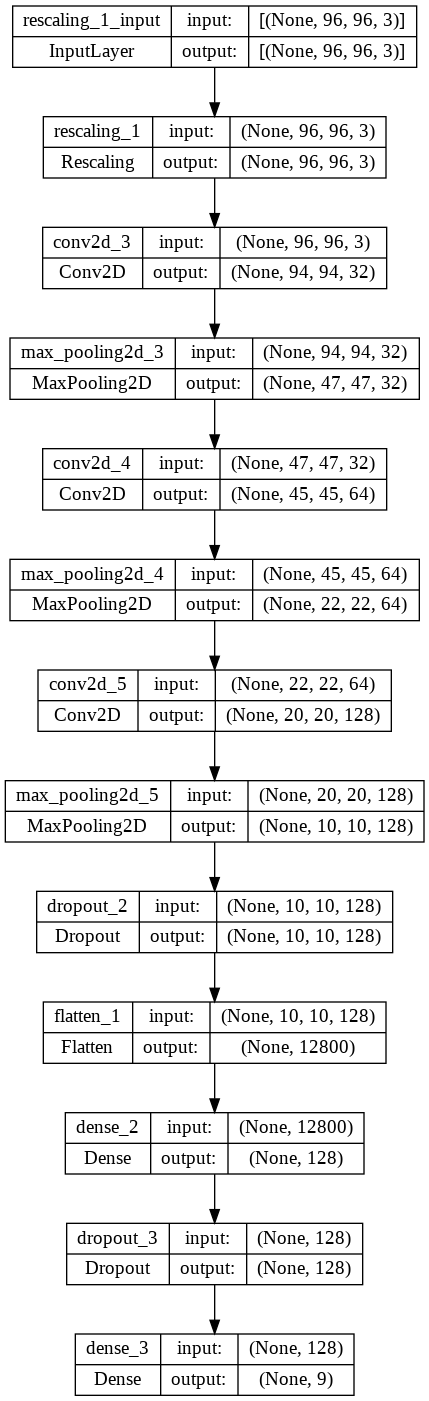

In [37]:
from tensorflow.keras.utils import plot_model
model_vgg16.build()
plot_model(model_vgg16, to_file='model_plot_vgg16.png', show_shapes=True, show_layer_names=True)

In [38]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
opt = Adam(lr=0.001)
model_vgg16.compile(optimizer=opt,loss="categorical_crossentropy",metrics=["accuracy"])
vgg16_checkpoint = ModelCheckpoint("vgg16_1.h5", monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='auto')

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [39]:
# train dataset 
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(96,96), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)


#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 22664 files belonging to 9 classes.
Using 18132 files for training.


In [40]:
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(96,96), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 22664 files belonging to 9 classes.
Using 4532 files for validation.


In [45]:
print(train_ds.file_paths)

['/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/AK/ISIC_0059146.jpg', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/MEL/ISIC_0028465.jpg', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/MEL/ISIC_0055412.jpg', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/MEL/ISIC_0014270_downsampled.jpg', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/BCC/ISIC_0056775.jpg', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/BCC/ISIC_0031378.jpg', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/MEL/ISIC_0059411.jpg', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/NV/ISIC_0027324.jpg', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/NV/ISIC_0002879_downsampled.jpg', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/BCC/ISIC_0033271.jpg', '/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input/Train/AK/ISIC_0058593.jpg', 

In [46]:


#print('val_ds @@@@',val_ds)
#history = model1.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[checkpoint,earlystop])
#print(train_ds.shape)
#hist = model1.fit(steps_per_epoch=20,generator=train_ds, validation_data= val_ds, validation_steps=10,epochs=20,callbacks=[checkpoint,earlystop])
hist = model_vgg16.fit(train_ds, validation_data= val_ds,epochs=20,callbacks=[vgg16_checkpoint,early])

Epoch 1/20
567/567 [==============================] - ETA: 0s - loss: 1.3085 - accuracy: 0.5255
Epoch 1: val_accuracy improved from -inf to 0.54634, saving model to vgg16_1.h5
567/567 [==============================] - 346s 610ms/step - loss: 1.3085 - accuracy: 0.5255 - val_loss: 1.2391 - val_accuracy: 0.5463
Epoch 2/20
567/567 [==============================] - ETA: 0s - loss: 1.2175 - accuracy: 0.5601
Epoch 2: val_accuracy improved from 0.54634 to 0.59025, saving model to vgg16_1.h5
567/567 [==============================] - 340s 599ms/step - loss: 1.2175 - accuracy: 0.5601 - val_loss: 1.1627 - val_accuracy: 0.5902
Epoch 3/20
567/567 [==============================] - ETA: 0s - loss: 1.1665 - accuracy: 0.5778
Epoch 3: val_accuracy improved from 0.59025 to 0.59753, saving model to vgg16_1.h5
567/567 [==============================] - 344s 607ms/step - loss: 1.1665 - accuracy: 0.5778 - val_loss: 1.1355 - val_accuracy: 0.5975
Epoch 4/20
567/567 [==============================] - ETA: 0s

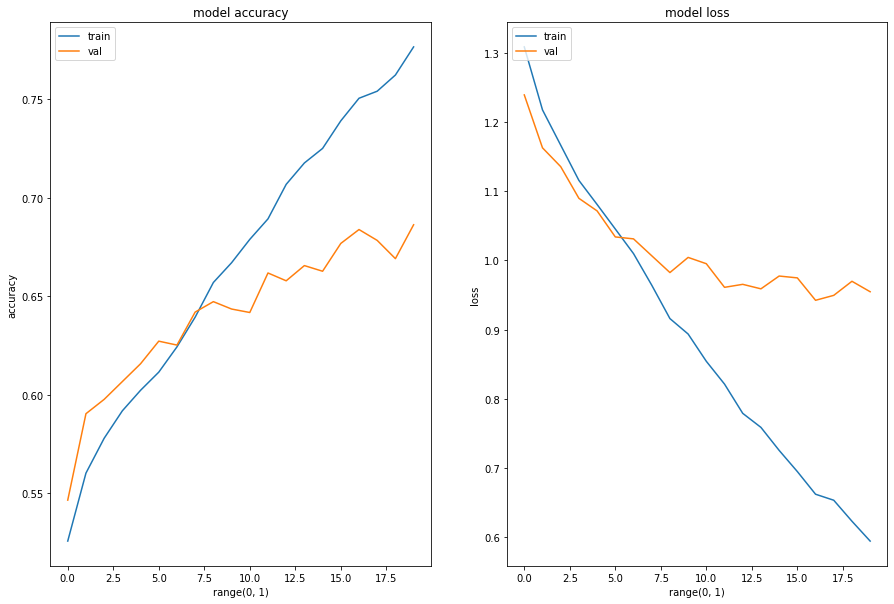

In [47]:
epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
tf.random.set_seed(1234)
np.random.seed(1234)
from glob import glob
for c in class_names:
  if (c=='BCC'):
    Test_image_path = os.path.join(test_ext_path,c, '*')
    Test_image = glob(Test_image_path)
    total_count = 0
    match_count = 0
    for tim in Test_image:
      t_image = load_img(tim,target_size=(96,96,3))
      img = np.expand_dims(t_image,axis=0)
      pred = model_vgg16.predict(img)
      pred = np.argmax(pred)
      pred_class = class_names[pred]
      print("Prediction ",pred_class," Class ",c," Tim ",tim)

      total_count=total_count+1
      if c==pred_class:
        match_count=match_count+1
print(" Total test count :",total_count)
print("Correct match_count:",match_count)

In [68]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    label_mode="categorical",
    batch_size=32,
    image_size=(96, 96),
    seed=123,
    validation_split=None,
    subset=None
)

Found 2533 files belonging to 9 classes.


In [69]:
test_results = model_vgg16.evaluate(test_ds)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

80/80 [==============================] - 12s 151ms/step - loss: 1.1273 - accuracy: 0.6431

Test Acc. 64.31%
